In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
from solver import PDE
import numpy as np
import torch
from mesh import Data, Mesh_Data
from boundary import Dirichlet, Periodic
#from boundary.Dirichlet import*
import matplotlib.pyplot as plt
from models.neural_net import MLP, Sine, block, Neural_Net, _init_weights
from models.activation import Sine, Swish

In [2]:
class Adv1d(PDE):
        
    def PDELoss(self, inputs, outputs):
        
        # compute gradients
        grads = self.compute_grad(outputs, inputs)
        
        # compute loss
        dpdx, dpdt = grads[:,0], grads[:,1]
        #print(dpdx.shape, dpdt.shape)
        u = inputs[:,2]
        return {'PDE': dpdt + u*dpdx}

pde = Adv1d(inputs=('x','t', 'u'),outputs=('p'))


pass


In [3]:
pde.input, pde.output

(('x', 't', 'u'), ('p',))

In [4]:
# define the mesh
x = np.linspace(0,1,20)
t = np.linspace(0,1,30)
u = np.linspace(-1,1,10)

In [5]:
mesh = Mesh_Data({'x':x, 't':t, 'u':u})

In [6]:
mesh.variable

('x', 't', 'u')

In [7]:
mesh.gen_data[:].shape

torch.Size([6000, 3])

In [8]:
pde.set_mesh(mesh)

In [9]:
# initial condition (t=0)
t0 = np.array([0])
_x,_t, _u = np.meshgrid(x,t0,u)
p0 = np.sin(2*np.pi*(_x-_u*_t))
initial_condition = Dirichlet({'x':x, 't':t0, 'u':u}, {'p':p0.reshape(-1)}, name='Initial Condition')

In [10]:
p0.reshape(-1).shape

(200,)

In [11]:
initial_condition.variable

[('x', 't', 'u'), ('p',)]

In [12]:
pde.add_boundary(initial_condition)

In [13]:
# periodic boundary
x1 = np.array([0.])
x2 = np.array([1.])
periodic = Periodic({'x':x1, 't':t, 'u':u},{'x':x2, 't':t, 'u':u},name = 'Periodic')
periodic.variable

[('x', 't', 'u'), ('x', 't', 'u')]

In [14]:
pde.add_boundary(periodic)

In [15]:
# from models import *
# from models.neural_net import _init_weights

In [16]:
#Neural_Net(3,100,1,3,torch.nn.ELU())

In [17]:
activation = Swish(1)
#activation = torch.nn.ELU()
in_dim = len(pde.input)
hid_dim = 100
out_dim = len(pde.output)
layers = 3
#net = MLP(3,1,3,100)
#net.apply(_init_weights)
net = Neural_Net(in_dim, hid_dim, out_dim, layers, act= activation)
# net.apply(_init_weights)

In [18]:
epochs = 50
optimizer = torch.optim.Adam(net.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, pct_start = 0.1, total_steps = epochs)
#criterion = torch.nn.MSELoss()
pde.compile(net, optimizer, scheduler)

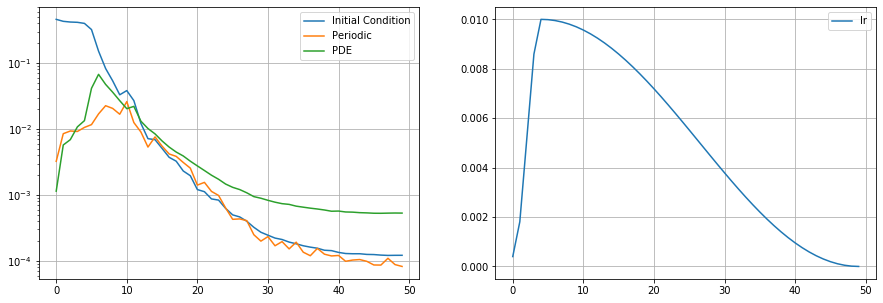

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  fig.canvas.print_figure(bytes_io, **kw)


Wall time: 1min 8s


In [19]:
batch_size = 256
%time hist = pde.solve(epochs, batch_size)

In [20]:
#hist['PDE']

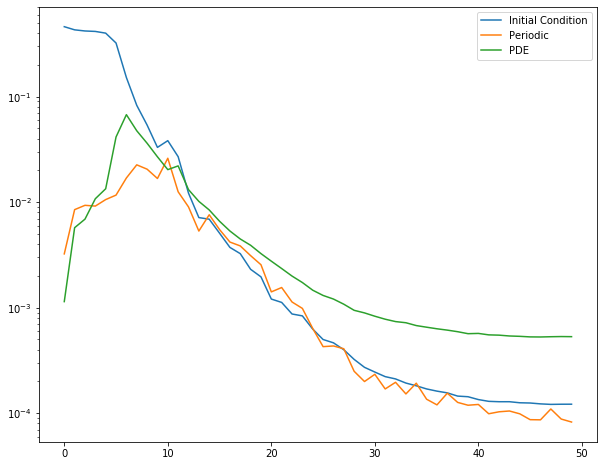

In [21]:
plt.figure(figsize=(10,8))
for key, value in hist.items():
    if key!= 'lr':
        plt.plot(hist[key],label=key)
        plt.legend()
    else:
        pass
    
    plt.yscale('log')

In [22]:
from matplotlib import animation, rc
rc('animation', html='html5')

def update_plot(i, x, u, t, p):
    ax.clear()
    pe = np.sin(2.*np.pi*(x-u*t[i]))
    ax.plot(x, pe, label=f"exact (u = {U})")
    ax.plot(x, p[i], '.k', label="solution")
    ax.set_xlabel("x", fontsize=14)
    ax.set_ylabel("p", fontsize=14, rotation=np.pi/2)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-1.2, 1.2])
    l2 = np.sqrt(np.sum((p[i]-pe)**2))
    ax.set_title(f"t = {t[i]:.3f} (L2 = {l2:.5f})")
    return ax

In [23]:
U = -0.5
x = np.linspace(0,1,30)
t = np.linspace(0,1,20)
u = np.array([U])
eval_mesh = Mesh_Data({'x':x, 't':t, 'u':u})

pred = pde.eval(eval_mesh)
pred = pred.numpy().reshape(len(t),-1)

fig = plt.figure()
ax = plt.subplot(111)
anim = animation.FuncAnimation(fig, update_plot, frames = len(t), fargs=(x,U,t,pred), interval = 300)
plt.close()

In [24]:
anim